In [1]:
import FunctionLib
import os
import gc
from tqdm import tqdm
import illustris_python as il
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# %matplotlib widget
basePath = "./sims.TNG/TNG50-1/output"

Snapshot_Init = 71
Snapshot_End = 99
Lbsg_Indices_Array = np.array(
    [117251, 300903, 324123, 329508, 382215,
        400973, 419618, 457431, 460722, 490814]
)

h = 0.6774  # km/Mpc

m_dm = 4.5e-5  # E10M_Sum
m_dm_h = m_dm * h

Critial_Density = 1.27e-8  # E10M_Sum/kpc^3
Critial_Density_h = Critial_Density / h**2  # E10M_Sum/(kpc/h)^3


---
### Vmax

In [2]:
Subhalo_Fields = ['SubhaloMassType', 'SubhaloVmax']
PartType4_Fields = ['Masses', 'GFM_Metallicity', 'GFM_StellarFormationTime']


In [3]:
# Load the Vmax data for Lbsg Samples
Lbsg_Vmax_List = list()
for Subhalo_Index in Lbsg_Indices_Array:

    Current_Snapshot = 99

    Subhalo_Dict = il.groupcat.loadSingle(
        basePath, Current_Snapshot, -1, Subhalo_Index)

    Lbsg_Vmax_List.append(Subhalo_Dict['SubhaloVmax'])


In [4]:
# Load the galaxies with stellar mass greater than 1E9 MassOfSun
Subhalos_Dict = il.groupcat.loadSubhalos(basePath, 99, fields=Subhalo_Fields)
condition = (Subhalos_Dict['SubhaloMassType'][:, 4] > 0.1) & (
    Subhalos_Dict['SubhaloMassType'][:, 4] < 100)
Galaxies_Indices = np.where(condition)[0]
Galaxies_Indices.shape


(2620,)

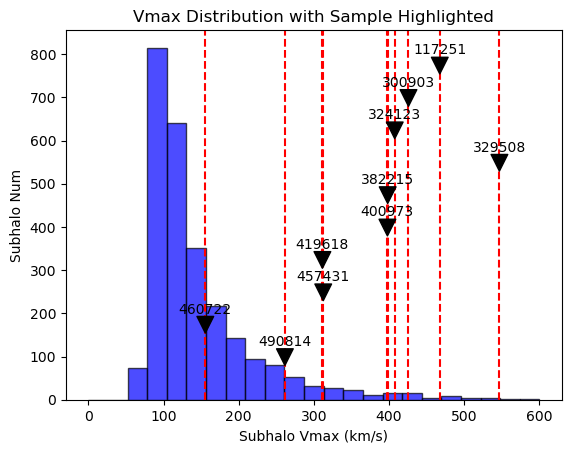

In [23]:
bins = np.linspace(0, 600, 24)

fig, ax = plt.subplots()

ax.hist(Subhalos_Dict['SubhaloVmax'][Galaxies_Indices],
        bins, alpha=0.7, color='blue', edgecolor='black')
ax.set_xlabel('Subhalo Vmax (km/s)')
ax.set_ylabel('Subhalo Num')
ax.set_title('Vmax Distribution with Sample Highlighted')

highlight_values = np.array(Lbsg_Vmax_List)
height = 800
for value in highlight_values:
    ax.axvline(x=value, color='red', linestyle='dashed',
               linewidth=1.5, label=f'Value: {value}')
    index = np.where(highlight_values == value)[0][0]
    ax.annotate(f'{Lbsg_Indices_Array[index]}', xy=(value, height-50), xytext=(value, height), ha='center', fontsize=10,
                arrowprops=dict(facecolor='black', shrink=0.1))
    height -= 75
plt.show()


This figure shows that the galxies with a huge HI clump tend to have higher circular velocity than others.

---
### Stars Ages

In [ ]:
Mass_Averaged_SFT = list()
for Subhalo_Id in tqdm(Galaxies_Indices):
    Subhalo_Dict = il.snapshot.loadSubhalo(
        basePath, Current_Snapshot, Subhalo_Id, partType=4, fields=PartType4_Fields)
    if (len(Subhalo_Dict)) == 1:
        continue
    Stars_Indices = np.where(Subhalo_Dict['GFM_StellarFormationTime'] > 0)[0]
    Mass_Averaged_SFT.append((Subhalo_Dict['Masses'][Stars_Indices]*Subhalo_Dict['GFM_StellarFormationTime']
                             [Stars_Indices]).sum()/Subhalo_Dict['Masses'][Stars_Indices].sum())


In [ ]:
bins = np.linspace(0, 1, 100)
plt.hist(Mass_Averaged_SFT, bins, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Star Formation Time')
plt.ylabel('Subhalo Num')
plt.title('Star Formation Time Distribution with Sample Highlighted')
for id in Lbsg_Indices_Array:
    plt.axvline(x=Mass_Averaged_SFT[np.where(Galaxies_Indices == id)[0][0]], color='red', linestyle='dashed',
                linewidth=1.5, label=f'Value: {Mass_Averaged_SFT[np.where(Galaxies_Indices==id)[0][0]]}')


---
### Gas Cooling

In [ ]:
def Cold_Gas_Mass(snap_num, subhalo_id):
    parttype0_fields = ['ElectronAbundance', 'InternalEnergy', 'Masses']
    subhalo_dict = il.snapshot.loadSubhalo(
        basePath, snap_num, subhalo_id, 0, fields=parttype0_fields)
    if len(subhalo_dict) == 1:
        return 0

    x_e = subhalo_dict['ElectronAbundance'].astype(np.float64)
    internal_energy = subhalo_dict['InternalEnergy'].astype(np.float64)
    gas_cell_masses = subhalo_dict['Masses'].astype(np.float64)

    m_p = 1.673E-24
    X_H = 0.76
    unit_switching = 1E10
    mean_molecular_weight = 4*m_p/(1+3*X_H+4*X_H*x_e)
    k_B = 1.38E-16
    gas_cell_temperature_in_Kelvin = 2/3*internal_energy / \
        k_B*unit_switching*mean_molecular_weight
    cold_gas_mass = 0

    for temperature, gas_cell_mass in FunctionLib.Binary_DataIter(gas_cell_temperature_in_Kelvin, gas_cell_masses):
        if temperature < 15000:
            cold_gas_mass += gas_cell_mass
    return cold_gas_mass


Sublink_Tree_Fields = ['SubfindID', 'SnapNum']


In [104]:
Cold_Gas_Mass_Matrix = np.zeros(
    shape=(Lbsg_Indices_Array.shape[0], Snapshot_End-Snapshot_Init+1))
Gas_Mass_Matrix = np.zeros(
    shape=(Lbsg_Indices_Array.shape[0], Snapshot_End-Snapshot_Init+1))
for lbsg_index in Lbsg_Indices_Array:
    print(lbsg_index)
    merger_tree = il.sublink.loadTree(
        basePath, Snapshot_End, lbsg_index, Sublink_Tree_Fields, onlyMPB=True)
    for current_snapshot, subfind_index in FunctionLib.Binary_DataIter(merger_tree['SnapNum'], merger_tree['SubfindID']):
        if current_snapshot < Snapshot_Init:
            break
        cgm = Cold_Gas_Mass(current_snapshot, subfind_index)
        gm = il.groupcat.loadSingle(
            basePath, current_snapshot, -1, subfind_index)['SubhaloMassType'][0]

        Cold_Gas_Mass_Matrix[np.where(Lbsg_Indices_Array == lbsg_index)[
            0], current_snapshot-Snapshot_Init] = cgm
        Gas_Mass_Matrix[np.where(Lbsg_Indices_Array == lbsg_index)[
            0], current_snapshot-Snapshot_Init] = gm
np.save('./Cold_Gas_Mass_Matrix.npy', Cold_Gas_Mass_Matrix)
np.save('./Gas_Mass_Matrix.npy', Gas_Mass_Matrix)


117251
300903
324123
329508
382215
400973
419618
457431
460722
490814
